In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

import tensorflow as tf

import os

from pyod.models.iforest import IForest

In [2]:
# Fijar la Semilla... fue necesario porque entre una corrida y otra cambiaban los resultados...
seed = 123

# Fijar la semilla en el generador de números aleatorios de Python
random.seed(seed)

# Fijar la semilla en NumPy
np.random.seed(seed)

# Fijar la semilla en TensorFlow
tf.random.set_seed(seed)

In [3]:
"""
from google.colab import drive
drive.mount('/content/drive')
""";

In [4]:
# Descargar los archivos por año desde:
# https://es-us.finanzas.yahoo.com/quote/BTC-USD/history?period1=1609459200&period2=1640908800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

os.getcwd()
os.chdir("dataset")

In [5]:
# Leer los archivos del directorio...

anhos = list(range(2021,2025,1))

# DataFrame inicial
df_concatenado = pd.DataFrame()

for anho in anhos:
    nombre_archivo = "BTC-USD " + "(" + str(anho) + ").csv"
    # print(nombre_archivo)

    df1 = pd.read_csv(nombre_archivo)
    # Agregar el DataFrame a la lista
    df_concatenado = pd.concat([df_concatenado, df1], ignore_index=True)

# Salvar el df...
df_concatenado.to_csv("bit_coin_tidy.csv", index = False)

df_bitcoin = pd.read_csv("bit_coin_tidy.csv", index_col="Date", parse_dates=["Date"])

# Eliminar si habían duplicados... DF Bitcoin Sin Duplicados...
df_bitcoin_sd = df_bitcoin.drop_duplicates()

if df_bitcoin.shape == df_bitcoin_sd.shape:
    print("No hubo duplicados...")
else:
    df_bitcoin = df_bitcoin_sd
    print("Duplicados eliminados, DF listo...")


No hubo duplicados...


In [6]:
df_bitcoin

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063,31971.914063,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...
2024-05-11,60793.355469,61451.152344,60492.625000,60793.710938,60793.710938,13842272968
2024-05-12,60793.503906,61818.156250,60632.601563,61448.394531,61448.394531,13800459405
2024-05-13,61451.218750,63422.660156,60769.839844,62901.449219,62901.449219,27889181179


In [7]:
df_bitcoin.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1.231000e+03
mean,37279.549222,38128.677243,36358.253173,37305.379911,37305.379911,3.196681e+10
std,14197.589434,14585.799769,13747.971386,14213.913783,14213.913783,2.009640e+10
min,15782.300781,16253.047852,15599.046875,15787.284180,15787.284180,5.331173e+09
25%,26236.743164,26604.758789,25862.258789,26234.259766,26234.259766,1.904418e+10
50%,35633.632813,36753.351563,34401.574219,35678.128906,35678.128906,2.801172e+10
75%,46772.486329,48004.308593,45608.328125,46785.658203,46785.658203,3.873153e+10
max,73079.375000,73750.070313,71334.093750,73083.500000,73083.500000,3.509679e+11


In [8]:
df_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1231 entries, 2021-01-01 to 2024-05-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1231 non-null   float64
 1   High       1231 non-null   float64
 2   Low        1231 non-null   float64
 3   Close      1231 non-null   float64
 4   Adj Close  1231 non-null   float64
 5   Volume     1231 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 67.3 KB


In [9]:
#Buscando atributo con valores constantes (desv stad ==0)
for columna in df_bitcoin.columns:
  if df_bitcoin[columna].std()==0.0:
    print(columna)

In [10]:
# Buscar valores negativos... Outlayers...
for columna in df_bitcoin.columns:
  numOutliers = 0
  for i in range(df_bitcoin.shape[0]):
    if df_bitcoin[columna][i]<0:
      numOutliers = numOutliers + 1

  if numOutliers>0:
    print(columna, numOutliers)

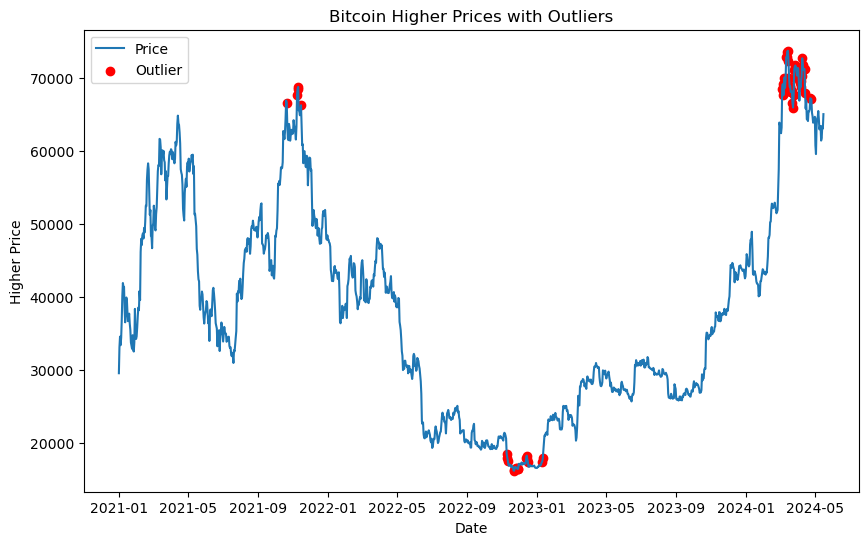

Outliers detectados:
                    Open          High           Low         Close  \
Date                                                                 
2021-10-21  66002.234375  66600.546875  62117.410156  62210.171875   
2021-11-08  63344.066406  67673.742188  63344.066406  67566.828125   
2021-11-09  67549.734375  68530.335938  66382.062500  66971.828125   
2021-11-10  66953.335938  68789.625000  63208.113281  64995.230469   
2021-11-15  65521.289063  66281.570313  63548.144531  63557.871094   
...                  ...           ...           ...           ...   
2024-04-11  70575.734375  71256.234375  69571.812500  70060.609375   
2024-04-12  70061.382813  71222.742188  65254.835938  67195.867188   
2024-04-13  67188.375000  67931.429688  60919.105469  63821.472656   
2024-04-22  64935.632813  67233.960938  64548.179688  66837.679688   
2024-04-23  66839.890625  67199.242188  65864.867188  66407.273438   

               Adj Close       Volume  Outlier  
Date               

In [11]:
# Detectar Outlayer usando pyOD... 

# Extraer los precios
prices = df_bitcoin['High'].values.reshape(-1, 1)

# Inicializar el modelo de Isolation Forest
model = IForest(contamination=0.05)
model.fit(prices)

# Predecir outliers
df_bitcoin['Outlier'] = model.predict(prices)

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df_bitcoin.index, df_bitcoin['High'], label='Price')
plt.scatter(df_bitcoin.index[df_bitcoin['Outlier'] == 1], df_bitcoin['High'][df_bitcoin['Outlier'] == 1], 
            color='red', label='Outlier', marker='o')
plt.xlabel('Date')
plt.ylabel('Higher Price')
plt.title('Bitcoin Higher Prices with Outliers')
plt.legend()
plt.show()

# Imprimir los outliers detectados
outliers = df_bitcoin[df_bitcoin['Outlier'] == 1]
print("Outliers detectados:")
print(outliers)

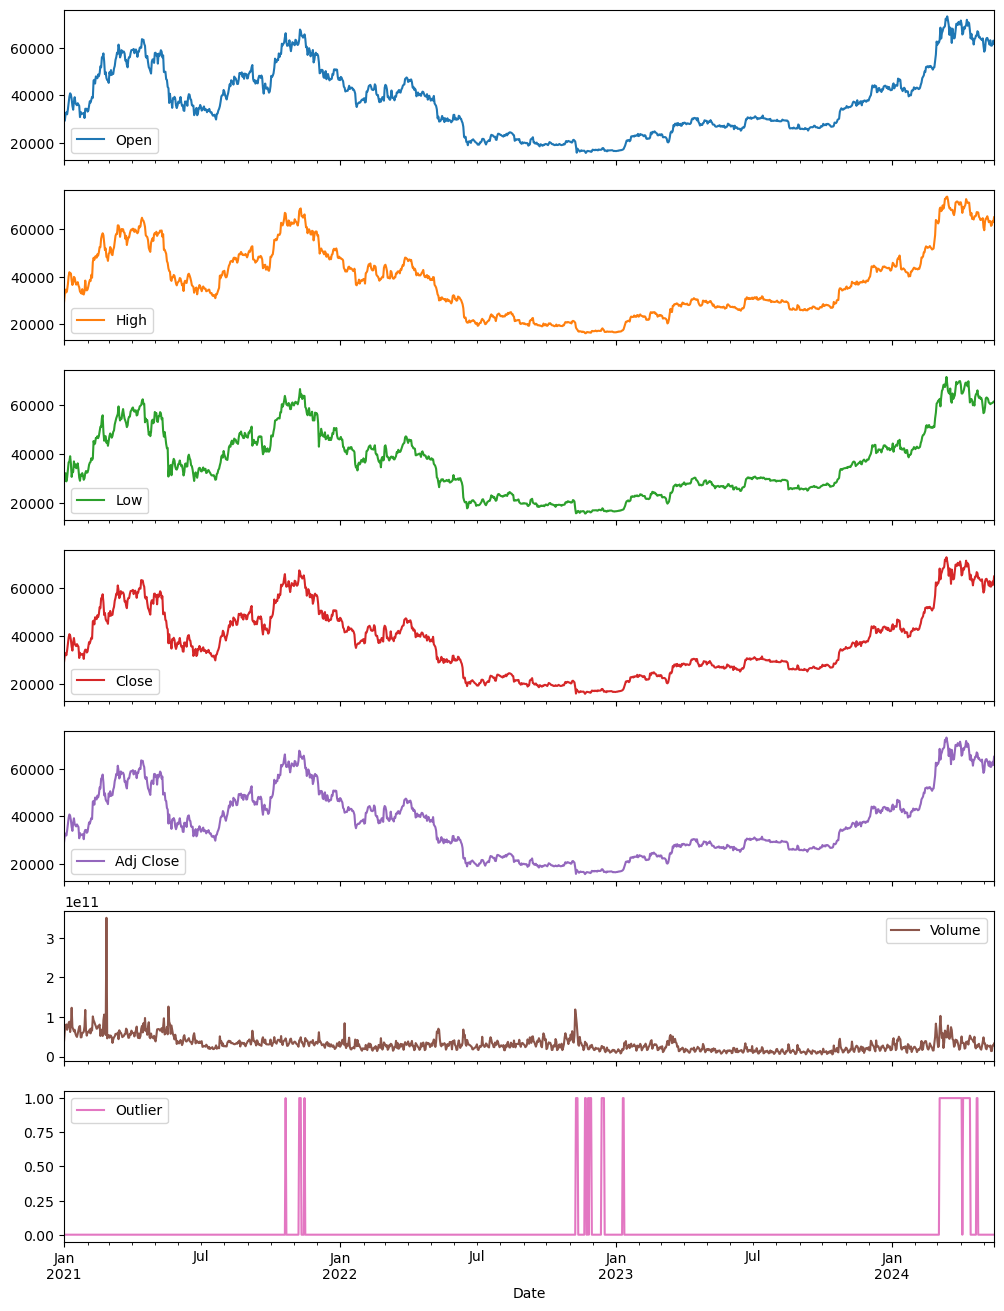

In [12]:
# Para visualizar todo el set de datos...

# Columnas del dataset
cols = df_bitcoin.columns

# Dibujar la totalidad de registros
N = df_bitcoin.shape[0]       # Número de registros
plots = df_bitcoin[cols][0:N] # Series de tiempo individuales
plots.index = df_bitcoin.index[0:N] # Variable tiempo
_ = plots.plot(subplots=True, figsize=(12,16))

In [13]:
# Análisis de la periodicidad del dataset... para ver si falta algún día...
df_bitcoin_time_diffs = df_bitcoin.index.to_series().diff().dt.days
print(df_bitcoin_time_diffs.value_counts())

Date
1.0    1230
Name: count, dtype: int64


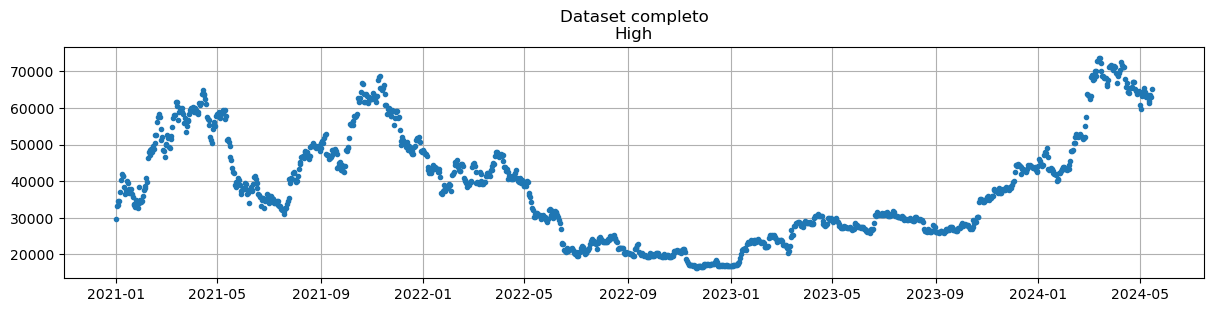

In [14]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Dataset completo\nHigh")
ax1.plot(df_bitcoin.High,marker='.',linewidth=0)
#ax1.plot(df_bitcoin.Low,marker='+',linewidth=0)
#ax1.plot(df_bitcoin.Open,marker='.',linewidth=0)
plt.grid(True)
plt.show()

In [15]:
set_entrenamiento = df_bitcoin[:'2023'].iloc[:,1:2]
set_validacion = df_bitcoin['2024':].iloc[:,1:2]

In [16]:
print(f"Tamaño del set de entrenamiento: {set_entrenamiento.shape[0]}, validación: {set_validacion.shape[0]}.")

Tamaño del set de entrenamiento: 1095, validación: 136.


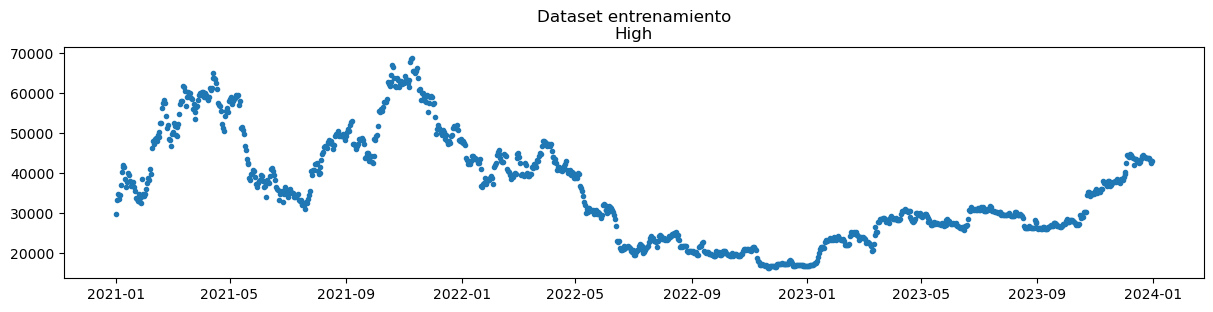

In [17]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Dataset entrenamiento\nHigh")
#ax1.plot(dataset.High,marker='.',linewidth=0)
#ax1.plot(dataset.Low,marker='^',linewidth=0)
ax1.plot( set_entrenamiento.High, marker = '.', linewidth = 0 )
plt.show()

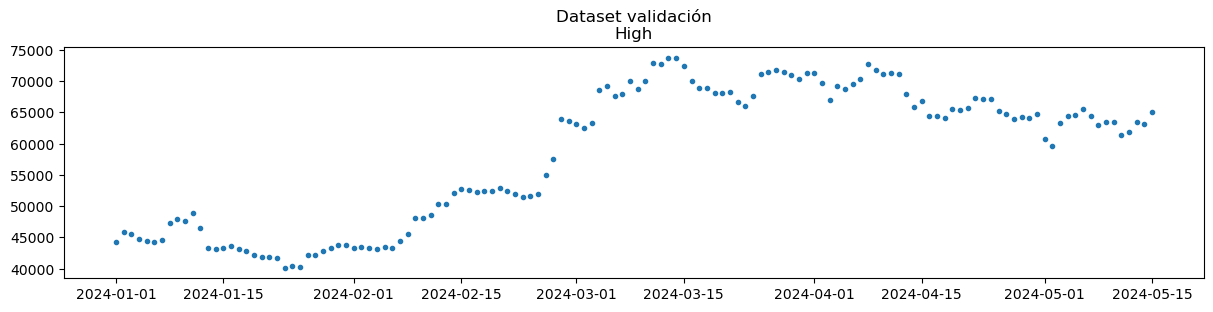

In [18]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Dataset validación\nHigh")
#ax1.plot(dataset.High,marker='.',linewidth=0)
#ax1.plot(dataset.Low,marker='^',linewidth=0)
ax1.plot( set_validacion.High, marker = '.', linewidth = 0 )
plt.show()

In [19]:
sc = MinMaxScaler( feature_range = (0,1) )
set_entrenamiento_escalado = sc.fit_transform( set_entrenamiento )

In [20]:
time_step = 90  # <-------- parametro: numero de valores a usar para predecir el siguiente
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

In [21]:
X_train.shape, Y_train.shape

((1005, 90), (1005,))

In [22]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [23]:
X_train.shape, Y_train.shape

((1005, 90, 1), (1005,))

In [24]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 100     # <-------- parametro: numero de neuronas

In [25]:
modelo = Sequential()
modelo.add( LSTM( units = na, input_shape = dim_entrada ) )
modelo.add( Dense( units = dim_salida ));

In [26]:
modelo.compile(optimizer='Adam', loss='mse') # <----- parametro: optimizer;

In [27]:
#tiempo estimado CPU: 1 min
#                GPU L4: 20 segs
%time modelo.fit( X_train, Y_train, epochs = 100, batch_size = 32, verbose = 0 ); #<------ parámetros: epochs, batch_size


CPU times: total: 52.3 s
Wall time: 1min 28s


In [28]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

C:\Users\mcd\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [29]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])

X_test = np.array( X_test )
X_test = np.reshape( X_test, (X_test.shape[0],X_test.shape[1],1)  )

In [30]:
X_test.shape, set_validacion.shape

((46, 90, 1), (136, 1))

In [31]:
prediccion = modelo.predict( X_test )
prediccion = sc.inverse_transform(prediccion)

2/2 [==============================] - 1s 9ms/step


In [32]:
df_prediccion = pd.DataFrame(prediccion, index=set_validacion.index[time_step:], columns=['High'])

In [33]:
df_prediccion['High'][0]

70252.78

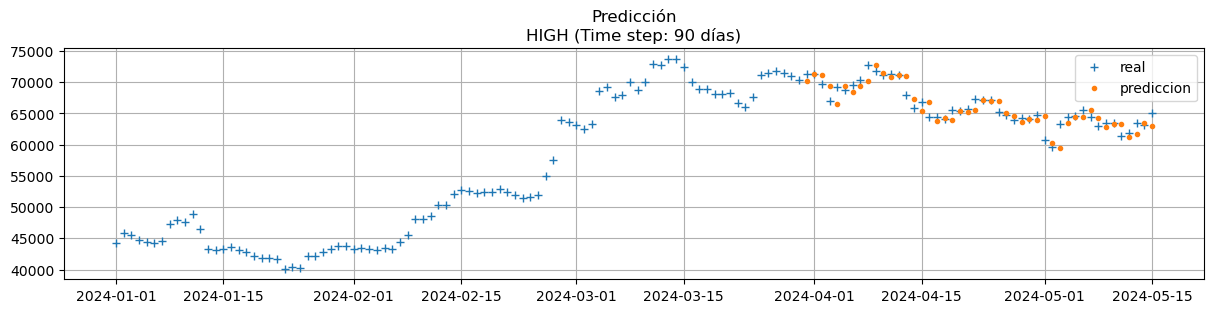

In [34]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title(f"Predicción\nHIGH (Time step: {time_step} días)")
ax1.plot( set_validacion.High, marker = '+', linewidth = 0 )
ax1.plot( df_prediccion['High'], marker = '.', linewidth = 0 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [35]:
# Difeerencias entre la predicción y el valor real...
# Agregar promedio...

maximo = None
minimo_valor = None
dif_list = []

for i in range(df_prediccion.shape[0]):
  diferencia = np.abs(set_validacion.High[i+time_step] - df_prediccion['High'][i])
  dif_list.append(diferencia)
  if( maximo == None ):
    maximo = diferencia
    minimo_valor = diferencia
  else:
    if diferencia  > maximo:
      maximo = diferencia
    else:
      if diferencia  < minimo_valor:
        minimo_valor = diferencia
print(f"Usando {time_step} días de Time Step se obtuvo que:",)
print("La diferencia máxima es", round(maximo, 3))
print("La diferencia mínima es", round(minimo_valor, 3))
print("La diferencia promedio es", round(np.mean(dif_list), 3))

Usando 90 días de Time Step se obtuvo que:
La diferencia máxima es 3918.605
La diferencia mínima es 23.828
La diferencia promedio es 1138.35


Con 90 días se obtuvo una menor diferencia máxima y una de las menores diferencias promedio.

Usando 90 días de Time Step se obtuvo que:
La diferencia máxima es 3918.605
La diferencia mínima es 23.828
La diferencia promedio es 1138.35

Usando 60 días de Time Step se obtuvo que:
La diferencia máxima es 4351.855
La diferencia mínima es 28.168
La diferencia promedio es 1227.287

Usando 30 días de Time Step se obtuvo que:
La diferencia máxima es 6181.879
La diferencia mínima es 4.062
La diferencia promedio es 1138.085

![alt text](timestep_90.png)

![alt text](timestep_60.png)

![alt text](timestep_30.png)